# Composers of classical music in *`.midi`* format
### Chieu Le Heng and Oliver James Tan
Identifying the composer of a piece of classical music is part of many music training programmes and tests (e.g. ABRSM aural tests). While speech recognition is a popular topic in AI, less work has been done on AI in music.

Much research has been done on working with `.mp3`/`.wav` files that store the sound waves of recordings of the pieces. Some approaches to working audio files include plotting a spectrogram and running image recognition on it, or computing the MFCC (Mel-Frequency Cepstrum Coefficients) of timeframes from the audio file and classifying based on that. However, much less work has been done with `.midi` files, which only encode when a note is played and at what amplitude.

In this project, we work on a dataset of `.midi` files from http://www.kunstderfuge.com/.

First, we tried using the python library `pretty_midi` to **extract features** such as tempo from the midi files, and classified the tracks based on the results. However, the results were appallingly bad, and we got accuracies of 21.41%. This reflects that simple metrics such as tempo and time signature are insufficient to represent composers' styles.

(For chord frequency, refer to `experiment-preprocessing.ipynb` and `experiment-classification.ipynb` for now) Next, we classify the files with using **chord frequency** and chord progression [1]. In music theory, chords are groups of notes that are usually played at the same time, and chords are to notes as words are to letters. In fact, chord progessions like the imperfect cadence are very popular and often used to end a section. Hence, chords can reveal stylistic choices that the composer might have made for a piece. `tf-idf` is used on the frequency of each chord, similar to how it n-grams are computed for words in NLP (Natural Language Processing). We find this approach successful in classifying the files, getting an accuracy of 55.61%.

Having successfully classified the files, we proceeded to **cluster** and **visualise** based on chord frequency, to observe what other patterns there are between the files, an approach that has not been tried before. We notice that ___.

Lastly, we **characterise** our model, and look at what chords and chord progressions our model has attributed to each composer. This information may prove useful for music students familiarising themselves with composers' styles.

### References
[1] A. Koh. Recognising Classical Composers using High-Level Music Features

[2] https://arxiv.org/pdf/1706.08928.pdf

### Code sources
https://github.com/achimkoh/midi-classification

First, we download the `.midi` files that have been converted to piano roll format, and convert them back to `.midi` files.

In [46]:
!pip install pygame
!pip install pretty_midi
!pip install pypianoroll
!pip install music21
import numpy as np
import pandas as pd
import music21
#from google.colab import drive
import os
import pickle
from tqdm.notebook import *
from pypianoroll import plot, Track, Multitrack

#drive.mount('/content/drive')
#os.chdir('/content/drive/My Drive/Colab Notebooks/ClassicalPianoRolls')

In [93]:
with open('music.pk', 'rb') as file:
    music = pickle.load(file)
music[0]

{'name': 'albeniz_suite_espanola_47_02_cataluna_(c)yogore.mid',
 'composer': 'Albeniz',
 'piece': <7368x128 sparse matrix of type '<class 'numpy.float64'>'
 	with 28387 stored elements in COOrdinate format>}

# Data handling

5992
{'Albeniz': 68, 'Alkan': 249, 'Bach, J.S': 1965, 'Bartók': 17, 'Beethoven': 290, 'Brahms': 150, 'Buxtehude': 63, 'Byrd': 113, 'Chopin': 252, 'Clementi': 45, 'Couperin': 1, 'Dandrieu': 163, 'Debussy': 149, 'Dvořák': 147, 'Fauré': 96, 'Frescobaldi': 86, 'Froberger': 45, 'Gesualdo da Venosa': 37, 'Handel': 496, 'Haydn, F': 237, 'Mahler': 32, 'Mendelssohn-B': 61, 'Mozart': 568, 'Mussorgsky': 29, 'Pachelbel, J': 86, 'Praetorius': 36, 'Pres (Despres)': 29, 'Rachmaninov': 25, 'Ravel': 50, 'Reger': 32, 'Saint-Saëns': 95, 'Satie': 47, 'Scarlatti, D': 555, 'Schubert': 281, 'Schumann': 102, 'Scriabin': 27, 'Stravinsky': 39, 'Tchaikovsky': 275, 'Telemann': 60, 'Vivaldi': 36}
{'Alkan': 249, 'Bach, J.S': 1965, 'Beethoven': 290, 'Brahms': 150, 'Byrd': 113, 'Chopin': 252, 'Dandrieu': 163, 'Debussy': 149, 'Dvořák': 147, 'Handel': 496, 'Haydn, F': 237, 'Mozart': 568, 'Scarlatti, D': 555, 'Schubert': 281, 'Schumann': 102, 'Tchaikovsky': 275}


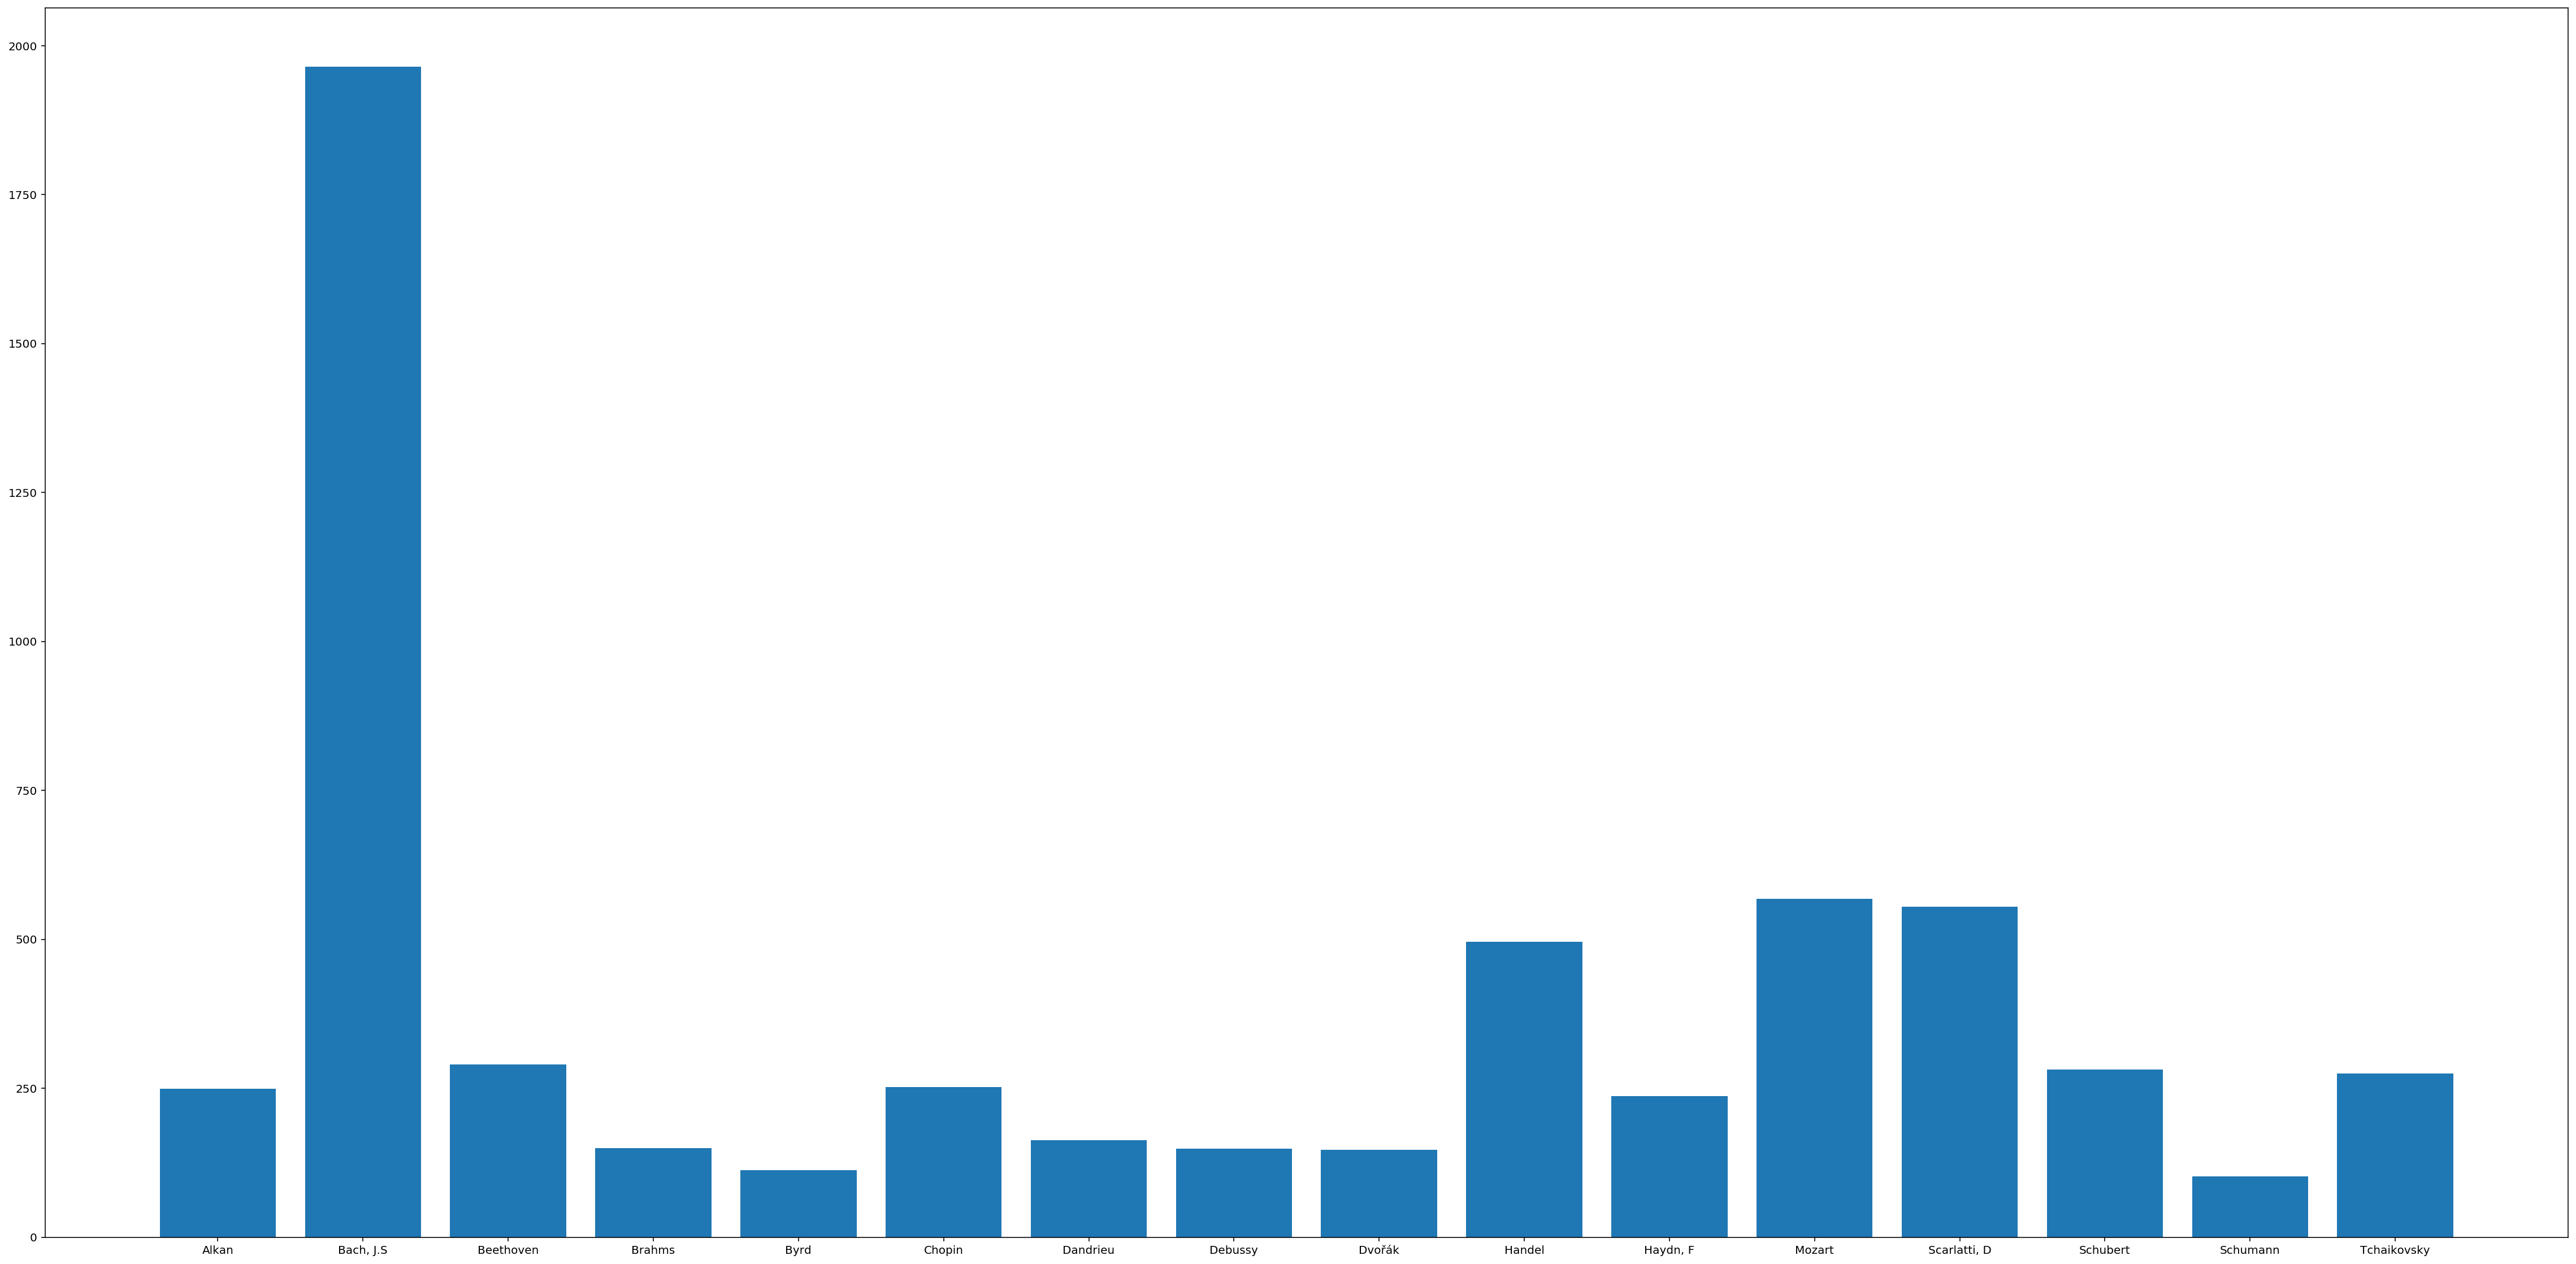

In [94]:
import random
from collections import Counter
import matplotlib.pyplot as plt
c = Counter([i["composer"] for i in music]).items()
fig, ax = plt.subplots(figsize=(40, 20))
c = dict(c)

# discard composers with less than 100 pieces
music = [piece for piece in music if c[piece["composer"]]>=100]
print(len(music))

print(c)
c = dict((i,j) for i,j in c.items() if j>=100)
ax.bar(c.keys(), c.values())
print(c)

In [95]:
# one-time terminal
import os, random
from unidecode import unidecode
random.seed(42)
sampler = random.sample(music, 200)
if not os.listdir("midi_files"):
  for i, piece in enumerate(tqdm(music)):
    track = Track(np.array(piece["piece"].todense())*127)
    Multitrack(tracks=[track], name=f'piece {i}, by {piece["composer"]}').write(f"midi_files/{i:04d}.midi")

In [101]:
# one-time terminal
if False:
    with open('mxl-list.txt', 'w') as file:
      for i, piece in enumerate(music):   
        piece["composer"] = unidecode(piece["composer"])
        file.write(f'{piece["composer"]}_{i:03d}.mxl\n')

In [97]:
from tqdm.notebook import *
import os
if False:
    for i in trange(5992):
        src = f'C:\\Users\\user\\Downloads\\classicall\\midi_files\\{i:04d}.midi'
        target = f'C:\\Users\\user\\Downloads\\classicall\\mxl_files\\{i:04d}.mxl'
        os.system(f'start "" "C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe" {src} --export-to {target}')

In [99]:
random.seed(42)
#if True:
composers = set(piece["composer"] for piece in music)
pieces_by_composer = dict((composer, []) for composer in composers)
for i, piece in enumerate(music):
    pieces_by_composer[piece["composer"]].append(i)

composers = selected_composers = ("Bach", "Mozart", "Beethoven", "Debussy")
pieces_by_composer["Bach"] = pieces_by_composer["Bach, J.S"].copy()
del pieces_by_composer["Bach, J.S"]

if False:
    i = 0
    with open('mxl-list.txt', 'w') as file:
        for composer in selected_composers:
            for piece in random.sample(pieces_by_composer[composer], 50):
                os.system(f'cp midi_files/{piece:04d}.midi midi_files/{i:03d}.midi')
                os.system(f'cp mxl_files/{piece:04d}.mxl mxl_files/{i:03d}.mxl')
                file.write(f'{composer}_{i:03d}.mxl\n')
                i += 1

random.seed(42)
music = [music[piece] for composer in selected_composers for piece in random.sample(pieces_by_composer[composer], 50)]
for piece in music:
    if piece["composer"]=='Bach, J.S': piece["composer"] = 'Bach'
print(len(music))

random.seed(42)
print( [piece for composer in composers for piece in random.sample(pieces_by_composer[composer], 50)])
    #len(music)
# in few_midi_files, 000.midi to 049.midi are by Bach,  050.midi to 099.midi by Mozart
#                    100.midi to 149.midi by Beethoven, 150.midi to 199.midi by Debussy

200
[1558, 477, 300, 1767, 812, 750, 706, 534, 1757, 458, 1634, 1765, 2076, 1365, 427, 1458, 1113, 314, 310, 440, 696, 725, 1283, 1481, 303, 1398, 656, 1715, 1579, 1685, 1108, 700, 1168, 1455, 818, 1906, 2029, 262, 1803, 1899, 575, 1678, 1114, 945, 567, 689, 2209, 1812, 938, 438, 4600, 4310, 4578, 4563, 4481, 4255, 4681, 4760, 4338, 4598, 4291, 4776, 4511, 4581, 4407, 4282, 4257, 4444, 4507, 4292, 4449, 4314, 4495, 4675, 4584, 4377, 4590, 4574, 4425, 4484, 4284, 4386, 4757, 4461, 4378, 4684, 4599, 4487, 4435, 4543, 4268, 4445, 4243, 4534, 4621, 4485, 4278, 4427, 4533, 4428, 2469, 2416, 2448, 2287, 2349, 2285, 2340, 2501, 2489, 2348, 2433, 2418, 2399, 2326, 2284, 2474, 2466, 2260, 2238, 2270, 2292, 2295, 2430, 2246, 2411, 2409, 2453, 2484, 2342, 2497, 2219, 2272, 2488, 2350, 2388, 2271, 2364, 2436, 2294, 2446, 2215, 2470, 2305, 2473, 2268, 2366, 2315, 2405, 2296, 2490, 3317, 3182, 3264, 3307, 3186, 3210, 3274, 3260, 3243, 3196, 3322, 3202, 3203, 3306, 3199, 3214, 3315, 3303, 3224, 3249,

# Visualisation

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26dd33193c8>)

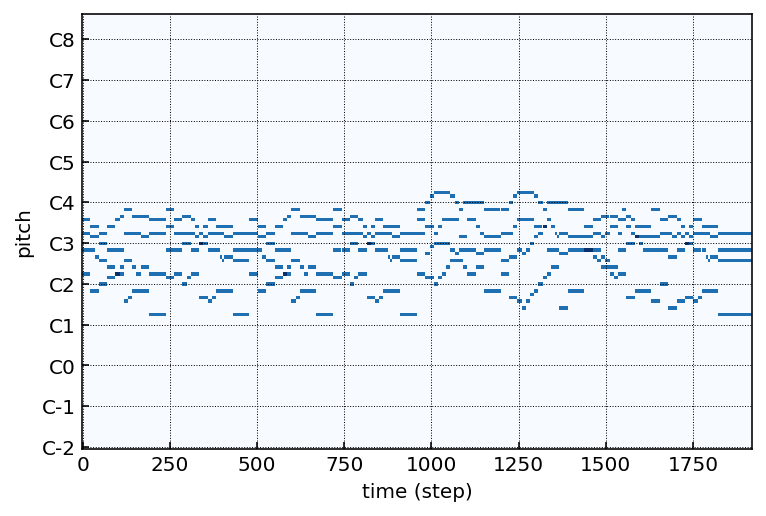

In [65]:
import matplotlib.pyplot as plt
piece = Track(np.array(music[0]["piece"].todense()))
plot(piece)

In [66]:
# playing around with pieces: keep, may be useful for prez
# source: ____
toPlay = False
if toPlay:
  import itertools
  from scipy.sparse import vstack
  import tqdm
  num_composers = 40
  chunk_size = 1024
  groups = itertools.groupby(sorted(music, key=lambda x: x["composer"]), lambda x: x["composer"])
  segments = []
  for composer, pieces in tqdm.tqdm_notebook(groups, total=num_composers):
      pieces_list = list(i["piece"].tocsr() for i in pieces)
      n = sum([i.shape[0] for i in pieces_list])//chunk_size
      if n!=0:
          trimmed_concat  = vstack(pieces_list)[:chunk_size*n]
          composer_segs = [(trimmed_concat[i:i+chunk_size], composer) for i in range(0,n*chunk_size,chunk_size)]
          segments.extend(composer_segs)
  random.shuffle(segments)
##################################################
from pypianoroll import Multitrack, Track
import pygame

def write_midi(arr, filename):
    Multitrack(tracks=[Track(arr*127)]).write(filename) # why *127? I don't understand
def play(filename):
    pygame.mixer.init()
    pygame.mixer.music.load(filename)
    # warning: doesn't work on Google Colab, works in local .ipynb
    pygame.mixer.music.play()
def test(num):
    answers = []
    for seg, comp in segments[:num]:
        write_midi(seg.toarray(), "temp2.mid")
        play("temp.mid")
        inp = input("Who was it?")
        if inp=="quit":
            break
        if len(inp)>=3 and inp.lower() in comp.lower():
            print(f"Correct the composer was {comp}")
            answers.append((comp, True))
        else:
            print(f"Incorrect the composer was {comp}")
            answers.append((comp, False))
    return answers
#test(7)

# 1. `pretty-midi`

In [69]:
import pretty_midi
# source: https://github.com/sandershihacker/midi-classification-tutorial/blob/master/midi_classifier.ipynb
def get_features(path):
    """
    This function extracts the features from a midi file when given its path.
    
    @input path: The path to the midi file.
    @type path: String
    
    @return: The extracted features.
    @rtype: List of float
    """
    #try:
    file = pretty_midi.PrettyMIDI(path)
    
    tempo = file.estimate_tempo()
    num_sig_changes = len(file.time_signature_changes)
    resolution = file.resolution
    ts_changes = file.time_signature_changes
    ts_1 = 4
    ts_2 = 4
    if len(ts_changes) > 0:
        ts_1 = ts_changes[0].numerator
        ts_2 = ts_changes[0].denominator
    return [tempo, num_sig_changes, resolution, ts_1, ts_2]
    #except Exception as e:
    #    print(e)
    #    return None

# original dataset doesn't have time signature data, and we can't find a package
#   that guesses it - oof
attr_lists = [[] for i in range(5)]
for i, piece in enumerate(music):
  for i, attr in enumerate(get_features(f'midi_files/{i:03d}.midi')):
    attr_lists[i].append(attr)
  if i==0:break

df = pd.DataFrame({
          'composer': [piece["composer"] for piece in music],
          'tempo': attr_lists[0],  
          'num_sig_changes': attr_lists[1], 
          'resolution': attr_lists[2], 
          'ts_1': attr_lists[3], 
          'ts_2': attr_lists[4],       
}, index=None)

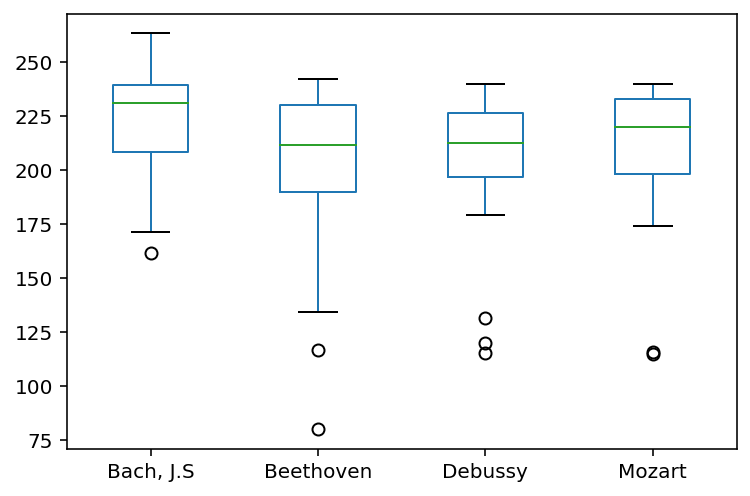

In [70]:
df.describe()
df.assign(index=df.groupby('composer').cumcount()).pivot('index','composer','tempo').plot(kind='box')
# https://stackoverflow.com/questions/48712274/matplotlib-box-plot-for-each-category#48712368

# Classification from attributes

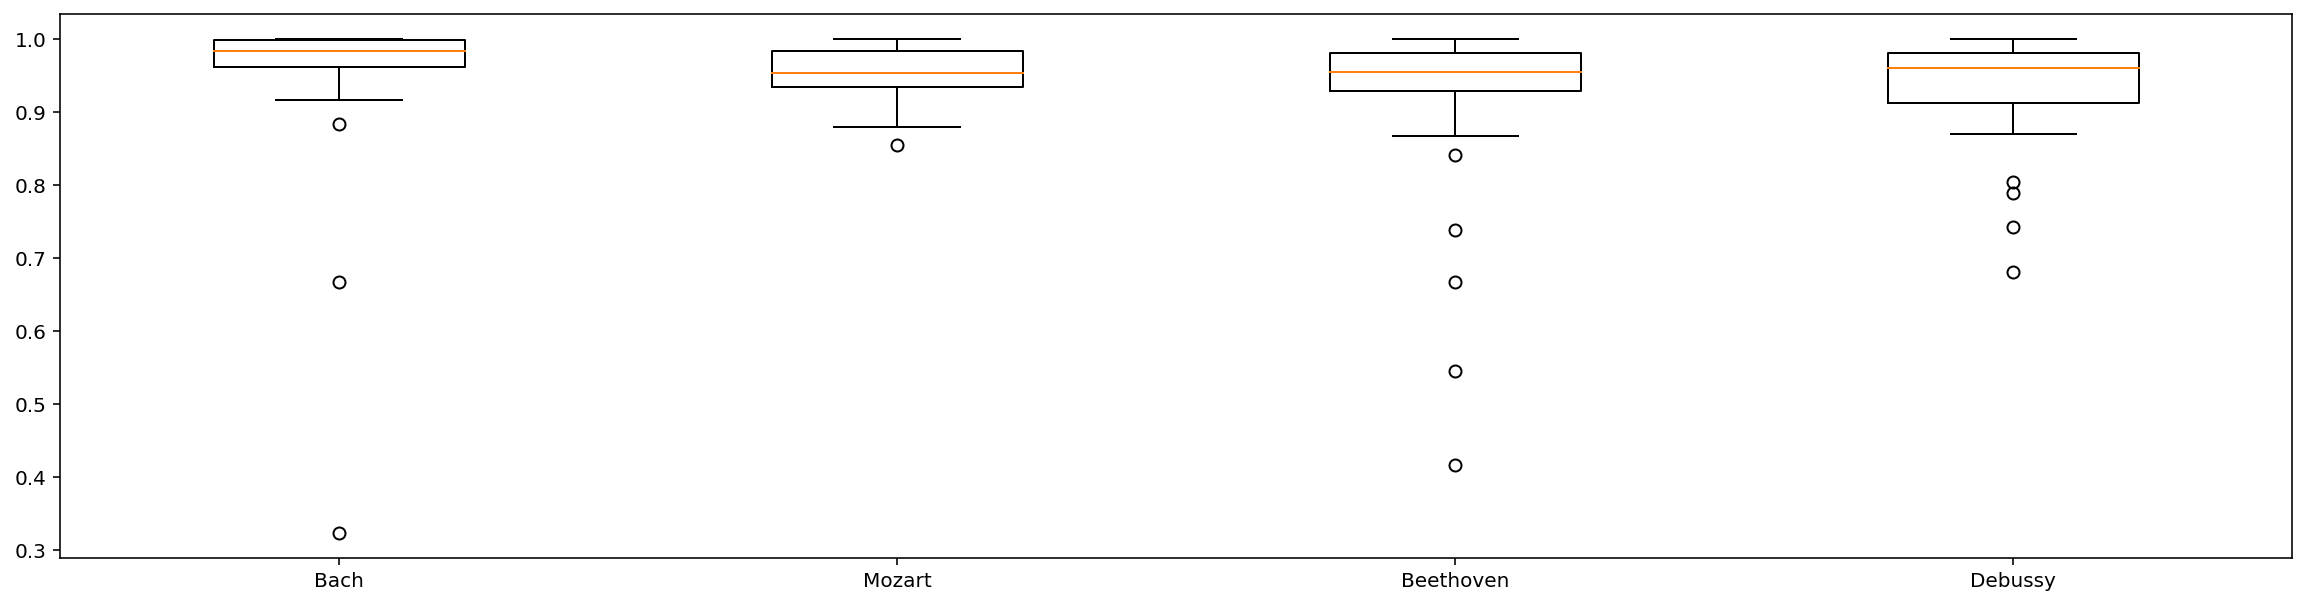

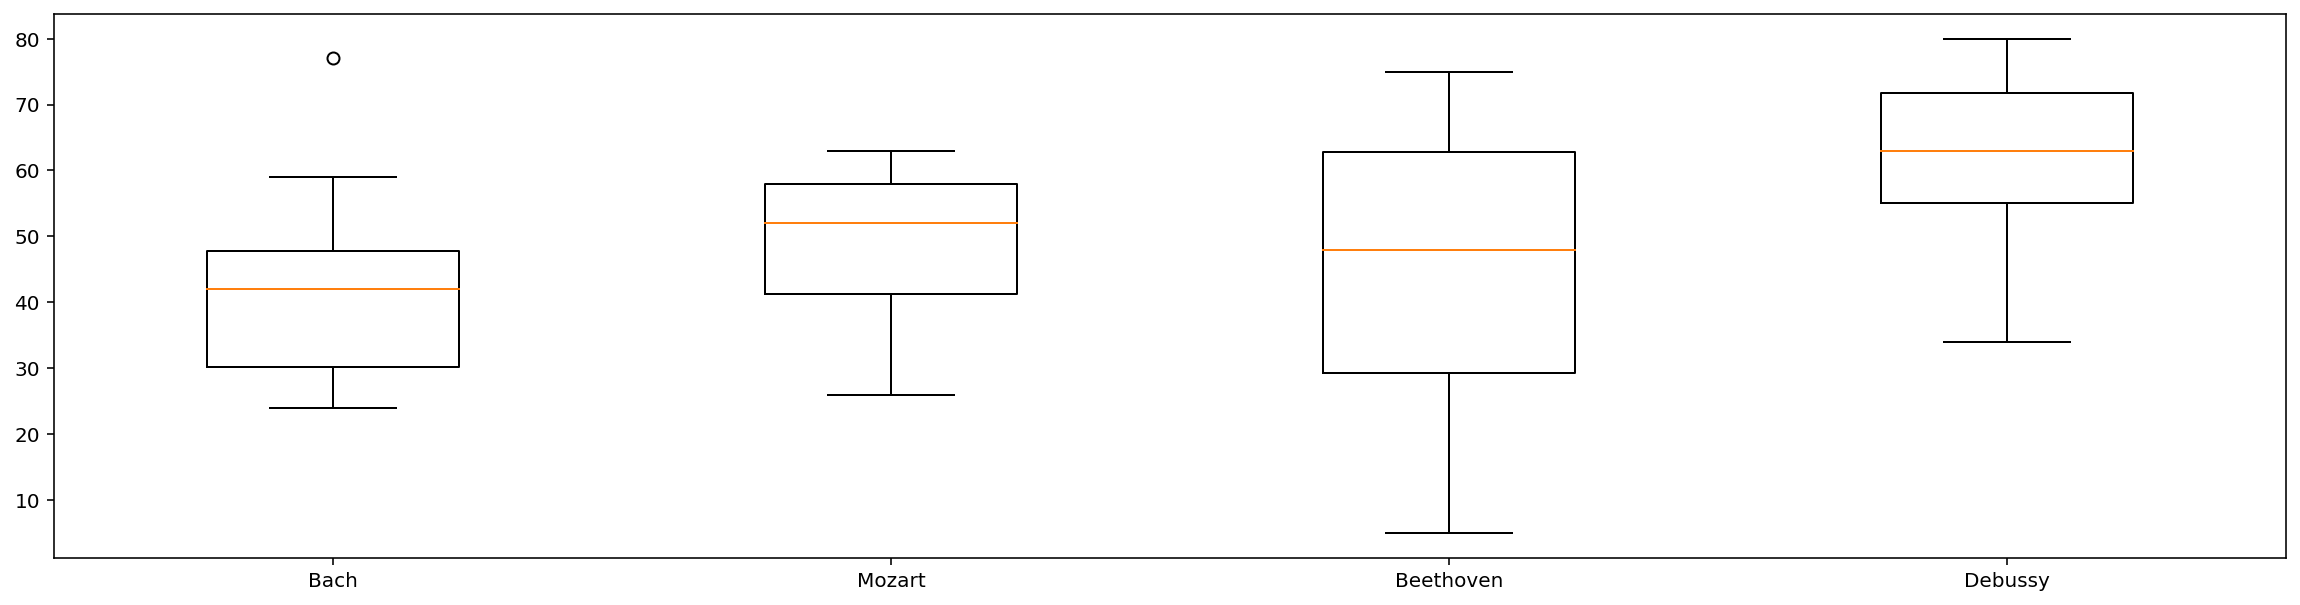

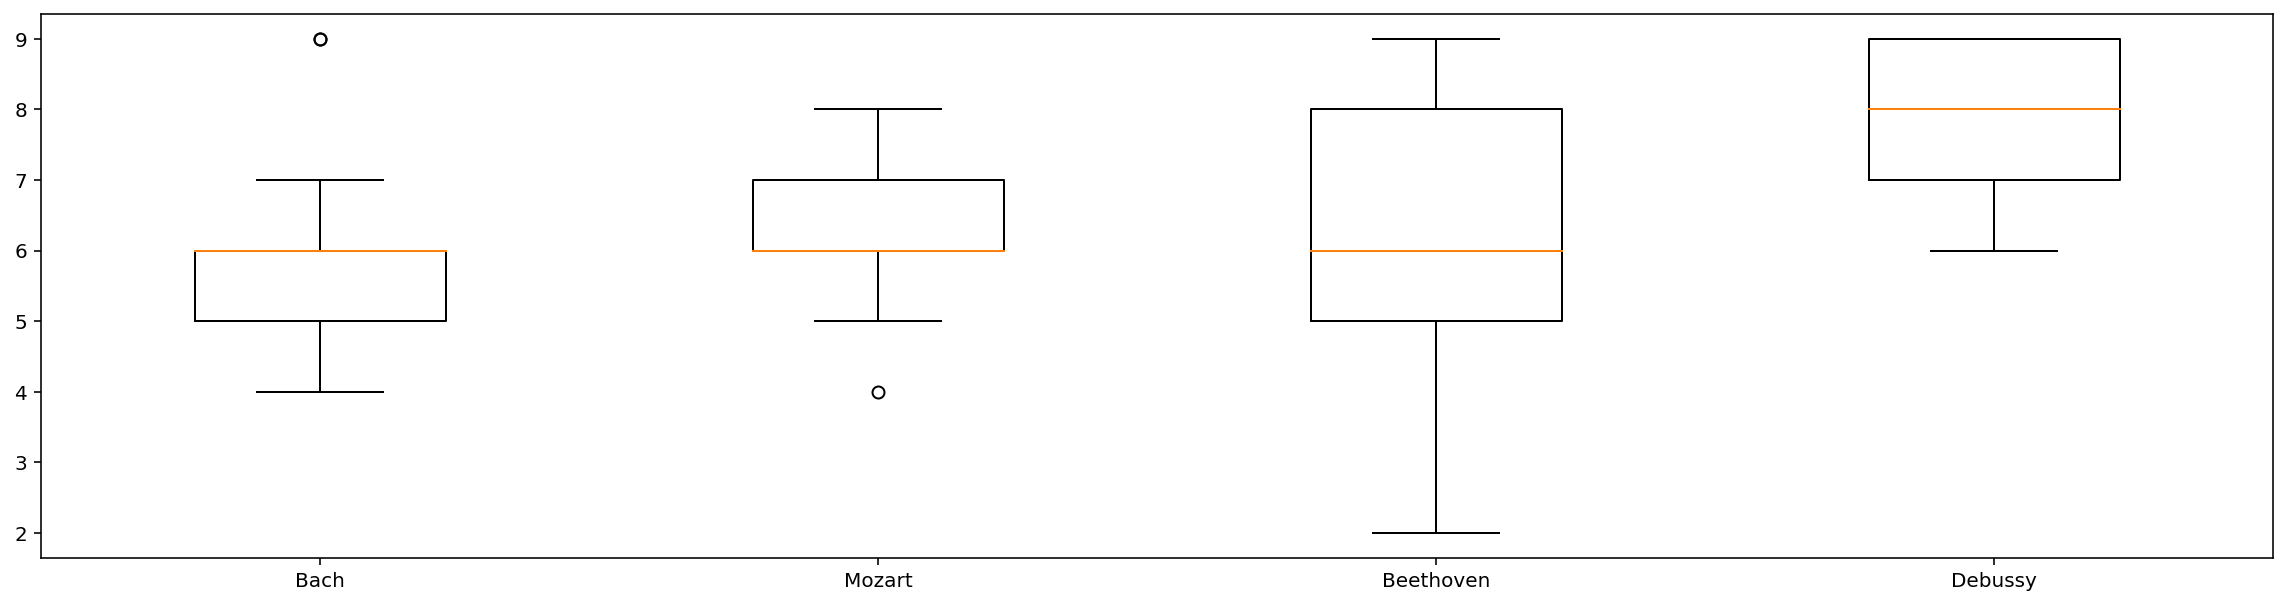

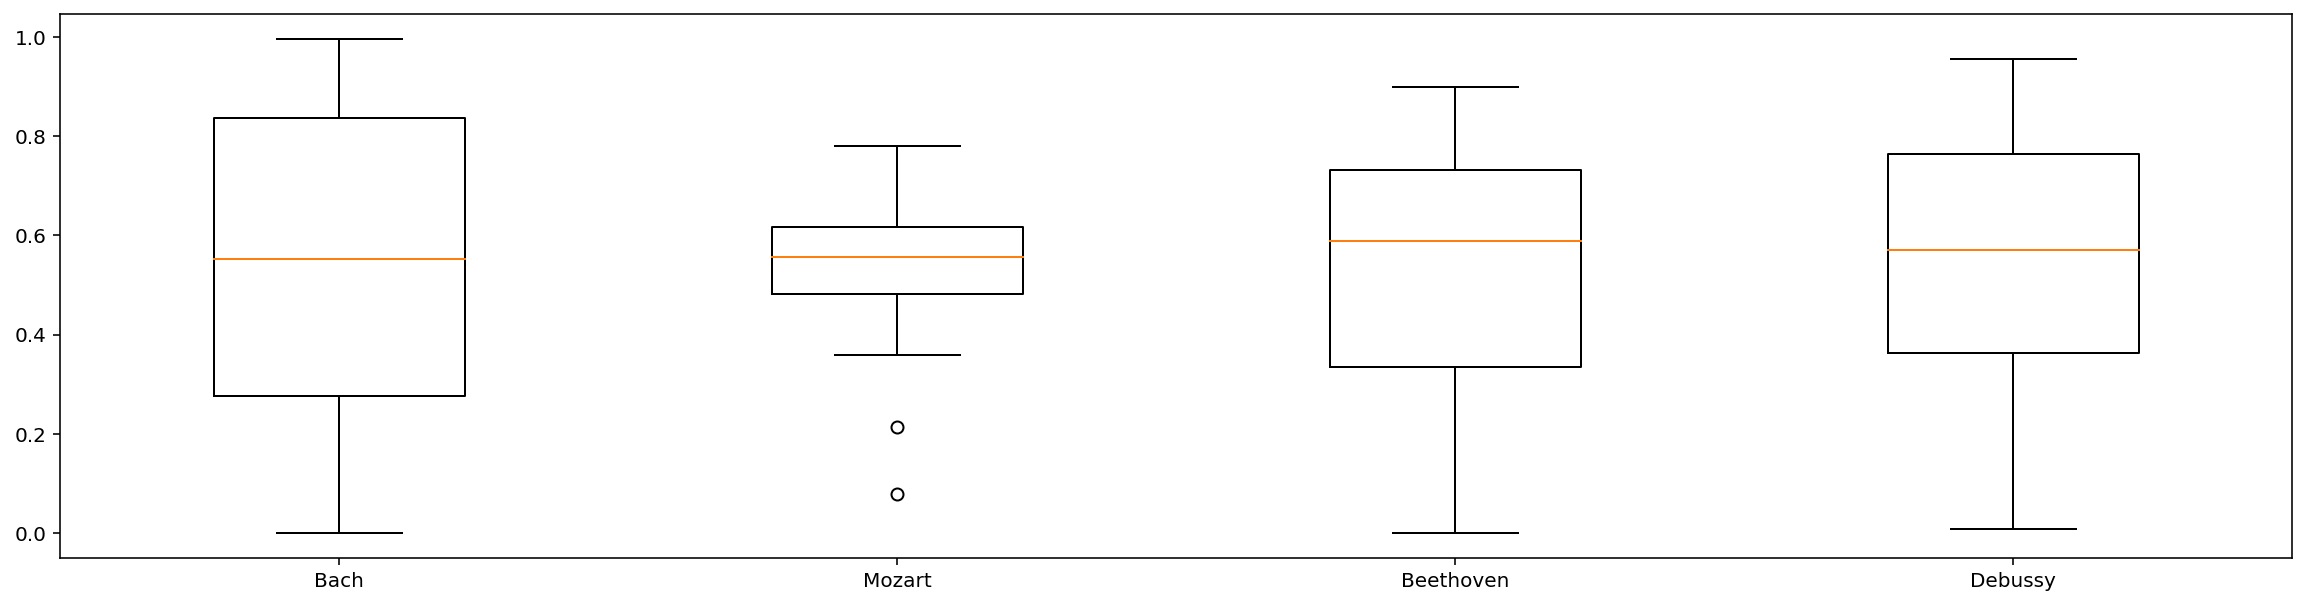

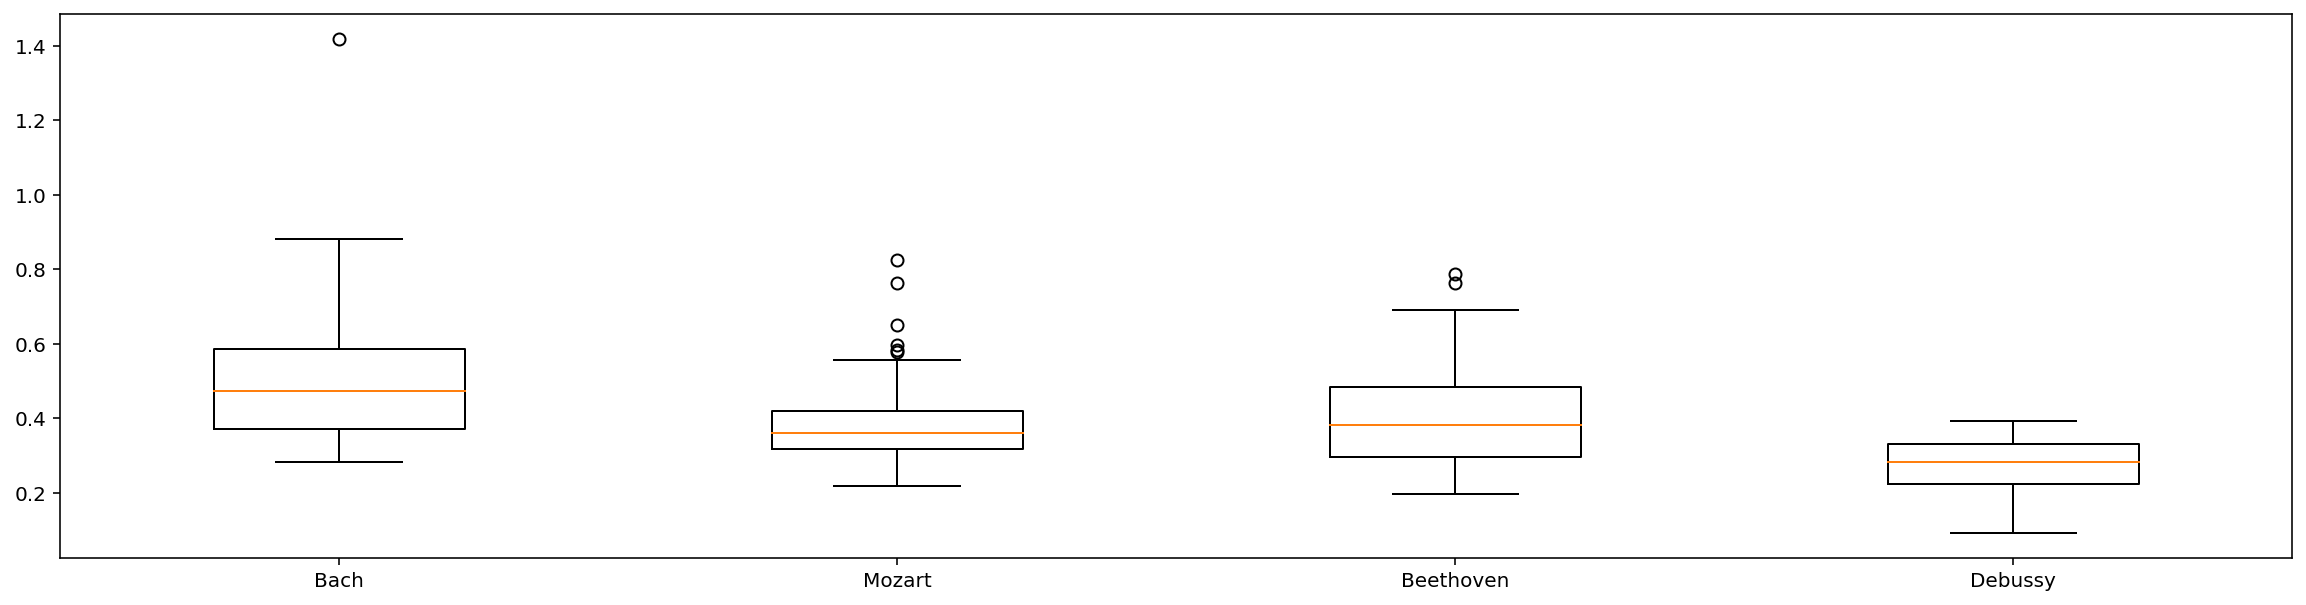

In [77]:
##################
# VISUALISATION
##################
from pypianoroll.metrics import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def dict_(): return dict((composer, []) for composer in composers)
arr, e, npu, npc, q, p, dip, isr =  dict_(), dict_(), dict_(), dict_(), dict_(), dict_(), dict_(), dict_()
# empty_beat rate, number of pitches used, number of pitch classes, qualified note rate, polyphonic rate
ear = []
npuar = []
npcar = []
par = []
israr = []
traits = pd.DataFrame

for piece in tqdm(music):
    arr = np.array(piece["piece"].todense())
    composer = piece["composer"]
    e[composer] += [empty_beat_rate(arr, 4)] # need time sig
    npu[composer] += [n_pitches_used(arr)]
    npc[composer] += [n_pitch_classes_used(arr)]
    #q += [qualified_note_rate(arr)]
    p[composer] += [polyphonic_rate(arr)]
    #dip += [drum_in_pattern_rate(arr, 4)]
    isr[composer] += [in_scale_rate(arr)]


    ear.append(e[composer][-1])
    npuar.append(npu[composer][-1])
    npcar.append(npc[composer][-1])
    par.append(p[composer][-1])
    israr.append(isr[composer][-1])
    #print(f'{polyphonic_rate(, beat_resolution=4):.3f}')

import matplotlib.pyplot as plt
'''plt.hist(e)
plt.figure(); plt.hist(npu)
plt.figure(); plt.hist(npc)
plt.figure(); plt.hist(p)
plt.figure(); plt.hist(isr)'''

for set_ in (e, npu, npc, p, isr):
    #plt.figure(figsize=(20,5))
    plt.figure()
    plt.boxplot(set_.values(), labels=set_.keys())

In [113]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

X = pd.DataFrame({
    'e': ear,
    'npu': npuar,
    'npc': npcar,
    'p': par,
    'isr': israr,
    'tempo': df['tempo'],
})
with open('indices.pickle', 'wb') as file:
    pickle.dump(X, file)

y = pd.DataFrame({
    'composer': [piece["composer"] for piece in music],
})

print('SPLITTING INTO TRAIN AND TEST')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
model = MLPClassifier()
model.fit(X_train, y_train)
print('score is', model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('CROSS_VAL_SCORE')
np.random.seed(42)
model_cv = MLPClassifier()
scores = cross_val_score(model_cv, X, y)
print(' '.join(f'{score:.3f}' for score in scores))
print(f'average classification accuracy = {sum(scores)/len(scores):.3f}')

print(f'''\n\nWe get a score of {sum(scores)/len(scores):.3f}.
Compare this with the score for tf-idf on chord frequency later.''')

SPLITTING INTO TRAIN AND TEST
score is 0.36
[[7 1 0 5]
 [4 7 0 1]
 [1 8 0 4]
 [6 2 0 4]]
              precision    recall  f1-score   support

        Bach       0.39      0.54      0.45        13
   Beethoven       0.39      0.58      0.47        12
     Debussy       0.00      0.00      0.00        13
      Mozart       0.29      0.33      0.31        12

    accuracy                           0.36        50
   macro avg       0.27      0.36      0.31        50
weighted avg       0.26      0.36      0.30        50

CROSS_VAL_SCORE


C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: 

0.475 0.425 0.450 0.375 0.400
average classification accuracy = 0.425


We get a score of 0.425.
Compare this with the score for tf-idf on chord frequency later.
(200,) [(  0, 1.        , 37, 5, 5.27964206e-01, 0.88137832, 246.05825243)
 (  1, 0.32398754, 28, 5, 1.81074766e-01, 1.41951642, 240.        )
 (  2, 0.94704861, 30, 6, 1.84027778e-01, 0.56831867, 238.45845042)
 (  3, 0.98180077, 49, 6, 6.12992611e-01, 0.60233962, 217.72119032)
 (  4, 0.97875244, 46, 6, 2.41764133e-01, 0.69104406, 240.        )
 (  5, 0.99737533, 52, 7, 8.48534558e-01, 0.47767152, 239.21353687)
 (  6, 0.98697632, 49, 6, 4.84198543e-01, 0.64836434, 233.66266761)
 (  7, 0.99481865, 29, 5, 0.00000000e+00, 0.45638103, 207.77176586)
 (  8, 1.        , 57, 7, 7.21554487e-01, 0.39479451, 181.02189781)
 (  9, 0.98099365, 33, 4, 4.46418255e-02, 0.35158856, 231.06931133)
 ( 10, 0.96142433, 37, 6, 4.72922849e-01, 0.60554267, 206.73269809)
 ( 11, 0.99940263, 44, 6, 6.22386499e-01, 0.52295359, 240.01291086)
 ( 12, 0.997275

AxisError: axis 1 is out of bounds for array of dimension 1

# 2. tf-idf by chord frequency

# 4. Characterisation (To-do)
Look at which features are most important in classifying the music/try to *explain* the classification. (e.g., look at the chord or pair of chords for tf-idf that match to each composer)


Change a chord or two and see if the classification changes. (can extend to adverserial neural networks that mess with the pieces and make them misclassified if we really, really have time)

Pass some *very* short/interesting pieces (like the school song) through the classifier, look at the labels, and see what that can tell us


In [115]:
print(X.to_records().shape, X.to_records())
print(np.asarray(X).shape, np.asarray(X))
np.delete(X.to_records(), 0, 1)

(200,) [(  0, 1.        , 37, 5, 5.27964206e-01, 0.88137832, 246.05825243)
 (  1, 0.32398754, 28, 5, 1.81074766e-01, 1.41951642, 240.        )
 (  2, 0.94704861, 30, 6, 1.84027778e-01, 0.56831867, 238.45845042)
 (  3, 0.98180077, 49, 6, 6.12992611e-01, 0.60233962, 217.72119032)
 (  4, 0.97875244, 46, 6, 2.41764133e-01, 0.69104406, 240.        )
 (  5, 0.99737533, 52, 7, 8.48534558e-01, 0.47767152, 239.21353687)
 (  6, 0.98697632, 49, 6, 4.84198543e-01, 0.64836434, 233.66266761)
 (  7, 0.99481865, 29, 5, 0.00000000e+00, 0.45638103, 207.77176586)
 (  8, 1.        , 57, 7, 7.21554487e-01, 0.39479451, 181.02189781)
 (  9, 0.98099365, 33, 4, 4.46418255e-02, 0.35158856, 231.06931133)
 ( 10, 0.96142433, 37, 6, 4.72922849e-01, 0.60554267, 206.73269809)
 ( 11, 0.99940263, 44, 6, 6.22386499e-01, 0.52295359, 240.01291086)
 ( 12, 0.9972752 , 43, 6, 8.03587648e-01, 0.62510546, 230.89477452)
 ( 13, 0.99180328, 42, 5, 5.37226776e-01, 0.36529358, 171.42857143)
 ( 14, 0.98494983, 36, 5, 2.32998885e-01,

AxisError: axis 1 is out of bounds for array of dimension 1